# Summary

* Analyze the `scRNAseq::BaronPancreasData` dataset as in the R vignette.

In [3]:
import os
import numpy as np
import pandas as pd
import scanpy as sc
from sklearn.preprocessing import LabelEncoder
import patsy
import devil

In [4]:
adata = sc.read_h5ad("tmp/baron_pancreas_full.h5ad")
adata

AnnData object with n_obs × n_vars = 8569 × 20125
    obs: 'donor', 'label'
    uns: 'X_name'

In [5]:
print(f"Number of genes: {adata.n_vars}")
print(f"Number of cells: {adata.n_obs}")

Number of genes: 20125
Number of cells: 8569


In [6]:
# Filter top 3 cell types
top_3_ct = adata.obs['label'].value_counts().head(3).index.tolist()
cell_filter = adata.obs['label'].isin(top_3_ct)
adata = adata[cell_filter, :].copy()
adata

AnnData object with n_obs × n_vars = 5928 × 20125
    obs: 'donor', 'label'
    uns: 'X_name'

In [7]:
# Filter low-expression genes
gene_counts = np.array(adata.X.sum(axis=0)).flatten()
gene_filter = gene_counts > 500
adata = adata[:, gene_filter].copy()
adata

AnnData object with n_obs × n_vars = 5928 × 7402
    obs: 'donor', 'label'
    uns: 'X_name'

In [8]:
# create a design matrix
def create_design_matrix_patsy(adata):
    """Create design matrix using patsy (R-like formula interface)."""
    
    # Extract metadata 
    metadata = adata.obs.copy()
    
    # Create design matrix using patsy formula
    # "~ label" creates intercept + dummy variables for label
    design_matrix = patsy.dmatrix("~ label", data=metadata, return_type='dataframe')
    
    print("Design matrix shape:", design_matrix.shape)
    print("Design matrix columns:", design_matrix.columns.tolist())
    
    return design_matrix.values

design_matrix = create_design_matrix_patsy(adata)

Design matrix shape: (5928, 3)
Design matrix columns: ['Intercept', 'label[T.beta]', 'label[T.ductal]']


In [9]:
fit = devil.fit_devil(
  adata,
  design_matrix,
  overdispersion = True,
  size_factors = True, 
  init_overdispersion = 100,
  verbose = True,
  n_jobs = 1, 
  offset = 1e-6
)

Fitting model for 7402 genes, 5928 samples, 3 features
GPU detected and will be used for acceleration
Computing size factors...
Size factor range: [0.973, 1.842]
Initializing beta coefficients...
Fitting beta coefficients...
Using GPU batch size: 7402


GPU beta fitting: 100%|██████████| 1/1 [00:15<00:00, 15.92s/it]


Fitting overdispersion parameters...


GPU overdispersion fitting: 100%|██████████| 1/1 [00:11<00:00, 11.63s/it]

Beta fitting completed: 96.7% genes converged
Overdispersion fitting completed
Model fitting complete!


In [10]:
# test differential expression
test_results = devil.test_de(fit, contrast = [0, 1, -1], max_lfc = 20)
test_results.head(n=3)

/home/nickyoungblut/dev/python/devil/python/devil/test.py:382: UserWarning: GPU implementation not yet available, using CPU
  warnings.warn("GPU implementation not yet available, using CPU")


,gene,lfc,se,stat,pval,padj
0,ITGB1,-2.540078,0.018521,-95.061692,0.0,0.0
1,SCG2,4.647876,0.052642,61.199725,0.0,0.0
2,ITGB6,-20.000000,0.014456,-4256.283399,0.0,0.0


/home/nickyoungblut/dev/python/devil/python/devil/plot.py:123: UserWarning: 260 genes have p-value = 0, setting to minimum non-zero value: 2.43e-307
  warnings.warn(


<Axes: title={'center': 'Volcano Plot'}, xlabel='$\\log_2$ Fold Change', ylabel='$-\\log_{10}$ Adjusted P-value'>

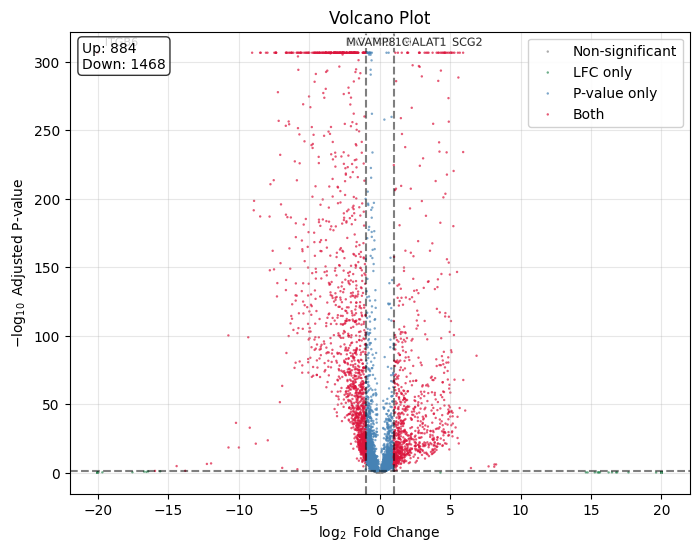

In [11]:
# create a volcano plot
devil.plot_volcano(
  test_results,
  lfc_threshold = 1,          # Log fold-change cutoff
  pval_threshold = 0.05,      # P-value significance threshold
  labels = True,              # Show gene labels
  point_size = 3
)

In [12]:
!uv pip list

Using Python 3.10.14 environment at: /home/nickyoungblut/dev/python/devil/.venv
Package                       Version        Editable project location
----------------------------- -------------- -------------------------------------------
alabaster                     1.0.0
anndata                       0.11.4
anyio                         4.9.0
argon2-cffi                   25.1.0
argon2-cffi-bindings          25.1.0
array-api-compat              1.12.0
arrow                         1.3.0
asttokens                     3.0.0
async-lru                     2.0.5
attrs                         25.3.0
babel                         2.17.0
beautifulsoup4                4.13.4
black                         25.1.0
bleach                        6.2.0
certifi                       2025.7.14
cffi                          1.17.1
charset-normalizer            3.4.2
click                         8.2.2
comm                          0.2.3
contourpy                     1.3.2
coverage                   